## coco dataset

### 生成coco datasret

refs:

https://blog.csdn.net/weixin_44052271/article/details/120475779



##### 生成image list

In [ ]:
from glob import glob
import random
import os, sys


data_dir = f'/data/ylw/datasets/test/imgs/*.jpg'
save_dir = f'/data/ylw/datasets/test/cocos'
split_ratio = 0.7


# 该目录存储图片数据
patch_fn_list = glob(data_dir)  
# 返回存储图片名的列表，不包含图片的后缀
patch_fn_list = [fn.split('\\')[-1][:-4] for fn in patch_fn_list]
# 将图片打乱顺序
random.shuffle(patch_fn_list)
 
# 按照7:3比例划分train和val
train_num = int(split_ratio * len(patch_fn_list))
train_patch_list = patch_fn_list[:train_num]
valid_patch_list = patch_fn_list[train_num:]

# produce train/valid/trainval txt file
split = ['train', 'val', 'trainval']

for s in split:
    # 存储文本文件的地址
    save_path = f'{save_dir}/train/' + s + '.txt'
 
    if s == 'train':
        with open(save_path, 'w') as f:
            for fn in train_patch_list:
                # 将训练图像的地址写入train.txt文件
                p, fn = os.path.split(fn)
                f.write('%s\n' % fn)
    elif s == 'val':
        with open(save_path, 'w') as f:
            for fn in valid_patch_list:
                # 将验证图像的地址写入val.txt文件
                p, fn = os.path.split(fn)
                f.write('%s\n' % fn)
    elif s == 'trainval':
        with open(save_path, 'w') as f:
            for fn in patch_fn_list:
                # 将所有图像名的编号写入trainval.txt文件
                p, fn = os.path.split(fn)
                f.write('%s\n' % fn)
    print('Finish Producing %s txt file to %s' % (s, save_path))

##### 移動數據

In [ ]:
import shutil


def my_move(datadir, trainlistdir,vallistdir,train_dir,val_dir):
    # 打开train.txt文件
    fopen = open(trainlistdir, 'r') 
    # 读取图片名称
    file_names = fopen.readlines()
    for file_name in file_names:
        file_name=file_name.strip('\n')
        # 图片的路径
        traindata = os.path.join(datadir, f'{file_name}.jpg')
        if not os.path.exists(traindata):
            print(f'not exist!!! {traindata}')
            continue
        save_file = os.path.join(train_dir, f'{file_name}.jpg')
        # train_dir
        # 若想复制可将move改为copy
        # shutil.move(traindata, save_file)
        shutil.copy(traindata, save_file)
    # 同上
    fopen = open(vallistdir, 'r')
    file_names = fopen.readlines()
    for file_name in file_names:
        file_name=file_name.strip('\n')
        valdata = os.path.join(datadir, f'{file_name}.jpg')
        if not os.path.exists(valdata):
            print(f'not exist!!! {valdata}')
            continue
        save_file = os.path.join(val_dir, f'{file_name}.jpg')
        # shutil.move(valdata, save_file)
        shutil.copy(valdata, save_file)

# 图片存储地址
datadir=r'/data/ylw/datasets/test/imgs'
# 存储训练图片名的txt文件地址
trainlistdir=r'/data/ylw/datasets/test/cocos/train/train.txt'
# 存储验证图片名的txt文件地址
vallistdir=r'/data/ylw/datasets/test/cocos/train/val.txt'

# coco格式数据集的train2017目录
train_dir=r'/data/ylw/datasets/test/cocos/train2017'
# coco格式数据集的val2017目录
val_dir=r'/data/ylw/datasets/test/cocos/val2017'
my_move(datadir, trainlistdir,vallistdir,train_dir,val_dir)

##### 生成coco數據集json

In [105]:

import json
import glob
import cv2 as cv
import os
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element




class tococo(object):
    def __init__(self, jpg_paths, label_path, save_path):
        self.images = []
        self.categories = []
        self.annotations = []
        # 返回每张图片的地址
        self.jpgpaths = jpg_paths
        self.save_path = save_path
        self.label_path = label_path
        # 可根据情况设置类别，这里只设置了一类
        self.class_ids = {
            'aeroplane': 0,
            'bicycle': 1,
            'bird': 2,
            'boat': 3,
            'bottle': 4,
            'bus': 5,
            'car': 6,
            'cat': 7,
            'chair': 8,
            'cow': 9,
            'diningtable': 10,
            'dog': 11,
            'horse': 12,
            'motorbike': 13,
            'person': 14,
            'pottedplant': 15,
            'sheep': 16,
            'sofa': 17,
            'train': 18,
            'tvmonitor': 19
        }
        self.class_id = range(0, 19, 20)
        self.coco = {}
 
    def json_to_coco(self):
        annid = 0
        for num, jpg_path in enumerate(self.jpgpaths):
 
            imgname = jpg_path.split('/')[-1].split('.')[0]
            img = cv.imread(jpg_path)
            jsonf = open(os.path.join(self.label_path,f'{imgname}.json')).read()  # 读取json
            labels = json.loads(jsonf)
            h, w = img.shape[:-1]
            self.images.append(self.get_images(imgname, h, w, num))
            for label in labels:
                # self.categories.append(self.get_categories(label['class'], self.class_id))
                px,py,pw,ph=label['x'],label['y'],label['w'],label['h']
                box=[px,py,pw,ph]
                print(box)
                self.annotations.append(self.get_annotations(box, num, annid, label['class']))
                annid = annid + 1
 
        self.coco["images"] = self.images
        self.categories.append(self.get_categories(label['class'], self.class_id))
        self.coco["categories"] = self.categories
        self.coco["annotations"] = self.annotations
        # print(self.coco)
 
    def xml_to_coco(self):
        annid = 0
        info = []
        for num, jpg_path in enumerate(self.jpgpaths):
 
            imgname = jpg_path.split('/')[-1].split('.')[0]
            img = cv.imread(jpg_path)
            xmlf = open(os.path.join(self.label_path,f'{imgname}.xml'))

            tree = ET.parse(xmlf)
            root = tree.getroot()
            objs = []
            img_info = {}
            for child in root:
                if child.tag == 'filename':
                    img_info['img_name'] = child.text
                if child.tag == 'size':
                    for item in child:
                        if item.tag == 'width':
                            width = item.text
                        if item.tag == 'height':
                            height = item.text
                        if item.tag == 'depth':
                            depth = item.text
                    img_info['w'] = width
                    img_info['h'] = height
                    img_info['d'] = depth
                if child.tag == 'object':
                    for idx, cld in enumerate(child):
                        if cld.tag == 'name':
                            cls = cld.text
                        if cld.tag == 'pose':
                            pose = cld.text
                        if cld.tag == 'truncated':
                            truncated = cld.text
                        if cld.tag == 'difficult':
                            difficult = cld.text
                        if cld.tag == 'bndbox':
                            for item in cld:
                                if item.tag == 'xmin':
                                    xmin = item.text
                                if item.tag == 'ymin':
                                    ymin = item.text
                                if item.tag == 'xmax':
                                    xmax = item.text
                                if item.tag == 'ymax':
                                    ymax = item.text
                    objs.append([cls, pose, truncated, difficult, int(xmin), int(ymin), int(xmax)-int(xmin), int(ymax)-int(ymin)])
            img_info['bboxes'] = objs
            info.append(img_info)
            # print(f'{info=}')

            h, w = img.shape[:-1]
            self.images.append(self.get_images(imgname, h, w, num))
            for label in img_info['bboxes']:
                # self.categories.append(self.get_categories(label['class'], self.class_id))
                px,py,pw,ph=label[4],label[5],label[6],label[7]
                box=[px,py,pw,ph]
                # print(box)
                self.annotations.append(self.get_annotations(box, num, annid, label[0]))
                annid = annid + 1
 
            self.categories.append(self.get_categories(label[0], self.class_ids[label[0]]))
            print(f'')
        self.coco["images"] = self.images
        self.coco["categories"] = self.categories
        self.coco["annotations"] = self.annotations
        # print(self.coco)

    def get_images(self, filename, height, width, image_id):
        image = {}
        image["height"] = height
        image['width'] = width
        image["id"] = image_id
        # 文件名加后缀
        image["file_name"] = filename+'.jpg'
        # print(image)
        return image
 
    def get_categories(self, name, class_id):
        category = {}
        category["supercategory"] = "Positive Cell"
        # id=0
        category['id'] = class_id
        # name=1
        category['name'] = name
        # print(category)
        return category
 
    def get_annotations(self, box, image_id, ann_id, calss_name):
        annotation = {}
        w, h = box[2], box[3]
        area = w * h
        annotation['segmentation'] = [[]]
        annotation['iscrowd'] = 0
        # 第几张图像，从0开始
        annotation['image_id'] = image_id
        annotation['bbox'] = box
        annotation['area'] = float(area)
        # category_id=0
        annotation['category_id'] = self.class_ids[calss_name]
        # 第几个标注，从0开始
        annotation['id'] = ann_id
        # print(annotation)
        return annotation
 
    def save_json(self):
        # self.json_to_coco()
        self.xml_to_coco()
        label_dic = self.coco
        print(f'{label_dic=}')
        instances_train2017 = json.dumps(label_dic)
        # 可改为instances_train2017.json
        f = open(os.path.join(os.path.join(save_path, 'instances_val2017.json')), 'w')
        f.write(instances_train2017)
        f.close()
 
# 可改为train2017，要对应上面的
jpg_paths = glob.glob('/data/ylw/datasets/test/cocos/train2017/*.jpg')
# 现有的标注文件地址
label_path = r'/data/ylw/datasets/test/anns'
# 保存地址
save_path = r'/data/ylw/datasets/test/cocos/annotations'
c = tococo(jpg_paths, label_path, save_path)
c.save_json()








































label_dic={'images': [{'height': 500, 'width': 330, 'id': 0, 'file_name': '000096.jpg'}, {'height': 333, 'width': 500, 'id': 1, 'file_name': '000094.jpg'}, {'height': 375, 'width': 500, 'id': 2, 'file_name': '000070.jpg'}, {'height': 333, 'width': 500, 'id': 3, 'file_name': '000082.jpg'}, {'height': 375, 'width': 500, 'id': 4, 'file_name': '000053.jpg'}, {'height': 335, 'width': 500, 'id': 5, 'file_name': '000031.jpg'}, {'height': 500, 'width': 335, 'id': 6, 'file_name': '000002.jpg'}, {'height': 500, 'width': 333, 'id': 7, 'file_name': '000043.jpg'}, {'height': 375, 'width': 500, 'id': 8, 'file_name': '000025.jpg'}, {'height': 375, 'width': 500, 'id': 9, 'file_name': '000097.jpg'}, {'height': 272, 'width': 500, 'id': 10, 'file_name': '000067.jpg'}, {'height': 500, 'width': 375, 'id': 11, 'file_name': '000028.jpg'}, {'height': 332, 'width': 500, 'id': 12, 'file_name': '000022.jpg'}, {'height': 375, 'width': 500, 'id': 13, 'file_name': '000015.jpg'}

### coco dataset API

In [2]:
from pycocotools.coco import COCO

In [3]:
json_file = r'/data/ylw/datasets/test/cocos/annotations/instances_val2017.json'
coco = COCO(json_file)
print(f'{coco.cats=}  \n{coco.getCatIds()=}')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
coco.cats={14: {'supercategory': 'Positive Cell', 'id': 14, 'name': 'person'}, 13: {'supercategory': 'Positive Cell', 'id': 13, 'name': 'motorbike'}, 15: {'supercategory': 'Positive Cell', 'id': 15, 'name': 'pottedplant'}, 6: {'supercategory': 'Positive Cell', 'id': 6, 'name': 'car'}, 7: {'supercategory': 'Positive Cell', 'id': 7, 'name': 'cat'}, 18: {'supercategory': 'Positive Cell', 'id': 18, 'name': 'train'}, 0: {'supercategory': 'Positive Cell', 'id': 0, 'name': 'aeroplane'}, 1: {'supercategory': 'Positive Cell', 'id': 1, 'name': 'bicycle'}, 8: {'supercategory': 'Positive Cell', 'id': 8, 'name': 'chair'}, 5: {'supercategory': 'Positive Cell', 'id': 5, 'name': 'bus'}, 2: {'supercategory': 'Positive Cell', 'id': 2, 'name': 'bird'}, 11: {'supercategory': 'Positive Cell', 'id': 11, 'name': 'dog'}, 16: {'supercategory': 'Positive Cell', 'id': 16, 'name': 'sheep'}, 3: {'supercategory': 'Positive Cell', 'id

In [7]:
import pandas as pd
import numpy as np


df = pd.DataFrame(coco.cats)
df

df = pd.DataFrame(np.array([coco.getCatIds()]))
df

,14,13,15,6,7,18,0,1,8,5,2,11,16,3,19
supercategory,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell,Positive Cell
id,14,13,15,6,7,18,0,1,8,5,2,11,16,3,19
name,person,motorbike,pottedplant,car,cat,train,aeroplane,bicycle,chair,bus,bird,dog,sheep,boat,tvmonitor


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,14,13,15,6,7,18,18,14,14,14,...,14,3,7,11,11,19,8,7,6,14


In [14]:
print(coco.dataset.keys())

dict_keys(['images', 'categories', 'annotations'])


#### 获取满足给定筛选条件的img ID。

函数说明

getImgIds有两个参数imgIds=[], catIds=[]，imgIds指定图像ID范围，catIds指定类别范围，函数会返回同时满足两者条件的图像ID

In [15]:
img_id_list = coco.getImgIds()
print(img_id_list)
print(len(img_id_list))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
38


#### 获取满足给定筛选条件的ann ID。

函数说明

getAnnIds函数有四个参数，imgIds=[]、catIds=[]、areaRng=[]、iscrowd=None，areaRng是图像区域，iscrowd是标注信息中的一个属性，输出的是满足条件的标注信息ID

In [16]:
img_id = img_id_list[2]
ann_ids = coco.getAnnIds(imgIds=[img_id])
print(ann_ids)

[4, 5]


#### 加载具有指定ID的ANN。

函数说明

loadAnns函数只有一个参数ids，代表输入的标注ID列表，输出对应ID的详细标注信息

In [17]:
anns = coco.loadAnns(ids=ann_ids)
print(anns)

[{'segmentation': [[]], 'iscrowd': 0, 'image_id': 2, 'bbox': [358, 163, 20, 34], 'area': 680.0, 'category_id': 15, 'id': 4}, {'segmentation': [[]], 'iscrowd': 0, 'image_id': 2, 'bbox': [313, 156, 45, 42], 'area': 1890.0, 'category_id': 15, 'id': 5}]


#### 用指定ID加载CAT。

函数说明

getCatIds函数三个参数，分别是catNms=[], supNms=[], catIds，catNms输入的是类别名，supNms输入的是父类名，catIds输入的是想要类别的id，返回的是满足条件的全部id

In [18]:
catidlist = coco.getCatIds()
print(catidlist)

[14, 13, 15, 6, 7, 18, 18, 14, 14, 14, 0, 7, 14, 1, 8, 13, 5, 18, 14, 2, 14, 2, 14, 11, 16, 18, 7, 11, 14, 3, 7, 11, 11, 19, 8, 7, 6, 14]


#### 使用指定ID加载CAT。

函数说明

loadCats函数只有一个参数ids，输入的是类别的id，得到的是类别id的详细信息

In [19]:
catcls = coco.loadCats(ids=catidlist)
print(catcls)

[{'supercategory': 'Positive Cell', 'id': 14, 'name': 'person'}, {'supercategory': 'Positive Cell', 'id': 13, 'name': 'motorbike'}, {'supercategory': 'Positive Cell', 'id': 15, 'name': 'pottedplant'}, {'supercategory': 'Positive Cell', 'id': 6, 'name': 'car'}, {'supercategory': 'Positive Cell', 'id': 7, 'name': 'cat'}, {'supercategory': 'Positive Cell', 'id': 18, 'name': 'train'}, {'supercategory': 'Positive Cell', 'id': 18, 'name': 'train'}, {'supercategory': 'Positive Cell', 'id': 14, 'name': 'person'}, {'supercategory': 'Positive Cell', 'id': 14, 'name': 'person'}, {'supercategory': 'Positive Cell', 'id': 14, 'name': 'person'}, {'supercategory': 'Positive Cell', 'id': 0, 'name': 'aeroplane'}, {'supercategory': 'Positive Cell', 'id': 7, 'name': 'cat'}, {'supercategory': 'Positive Cell', 'id': 14, 'name': 'person'}, {'supercategory': 'Positive Cell', 'id': 1, 'name': 'bicycle'}, {'supercategory': 'Positive Cell', 'id': 8, 'name': 'chair'}, {'supercategory': 'Positive Cell', 'id': 13, 

#### 使用指定的ID加载imgs。

函数说明

loadImgs只有一个参数ids，输入的是个图像id的列表，如果是一个图像直接输入id也可以。

输出的是json文档中对应的图像信息，输入的img_id同输出中的'id': 252219

之后就可以读取图像信息了，如图像名，图像宽、高

In [20]:
img_id = img_id_list[2]
img_info = coco.loadImgs(ids=[img_id])
print(img_info)

[{'height': 375, 'width': 500, 'id': 2, 'file_name': '000070.jpg'}]


##### refs

https://blog.csdn.net/XDH19910113/article/details/125299598


imgIds=[0, 37, 7, 8, 9, 12, 15, 18, 20, 22, 28]
index=array([10])
{'height': 330, 'width': 500, 'id': 28, 'file_name': '000085.jpg'}
annIds=[69, 70]  
anns=[{'segmentation': [[]], 'iscrowd': 0, 'image_id': 28, 'bbox': [22, 70, 232, 257], 'area': 59624.0, 'category_id': 14, 'id': 69}, {'segmentation': [[]], 'iscrowd': 0, 'image_id': 28, 'bbox': [338, 12, 162, 187], 'area': 30294.0, 'category_id': 14, 'id': 70}]


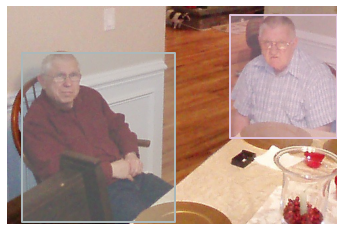

In [23]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np


data_dir = f'/data/ylw/datasets/test/cocos/train2017'


catIds = coco.getCatIds(catNms=['person'])
imgIds = coco.getImgIds(catIds=catIds)
print(f'{imgIds=}')

index = np.random.choice(range(len(imgIds)), 1)
print(f'{index=}')

img = coco.loadImgs(imgIds[index[0]])[0]
print(img)

i = io.imread(os.path.join(data_dir, img['file_name']))
#i = cv2.imread(os.path.join(r'E:\datasets\coco\val2017', img['file_name']))

plt.imshow(i)
plt.axis('off')

annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print(f'{annIds=}  \n{anns=}')
coco.showAnns(anns, draw_bbox=True)

plt.savefig('testblueline.jpg')
plt.show();

Annotation file: /data/ylw/datasets/test/cocos/annotations/instances_val2017.json
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
"person" 对应的序号: 14
person34张, 分别是： [0, 0, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 12, 15, 15, 15, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 20, 22, 22, 28, 28, 37]
"1" 对应的类别名称: [{'supercategory': 'Positive Cell', 'id': 1, 'name': 'bicycle'}]
包含person的图片共有：2张
imgId=13
图像13的信息如下：
{'height': 375, 'width': 500, 'id': 13, 'file_name': '000015.jpg'}
imPath='/data/ylw/datasets/test/cocos/train2017/000015.jpg'


(0.0, 1.0, 0.0, 1.0)

(-0.5, 499.5, 374.5, -0.5)

图像13包含3个ann对象，分别是:
[32]
len(anns)=1  anns=[{'segmentation': [[]], 'iscrowd': 0, 'image_id': 13, 'bbox': [77, 136, 283, 222], 'area': 62826.0, 'category_id': 1, 'id': 32}]


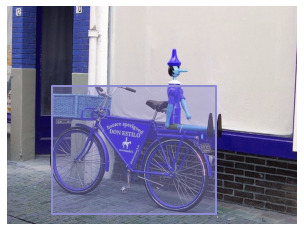

In [163]:
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import random



#1、定义数据集路径
cocoRoot = f'/data/ylw/datasets/test/cocos'
dataType = "val2017"
annFile = os.path.join(cocoRoot, f'annotations/instances_{dataType}.json')
print(f'Annotation file: {annFile}')

#2、为实例注释初始化COCO的API
coco=COCO(annFile)


#3、采用不同函数获取对应数据或类别
ids = coco.getCatIds('person')[0]    #采用getCatIds函数获取"person"类别对应的ID
print(f'"person" 对应的序号: {ids}') 
imgIds = coco.catToImgs[ids]
print(f'person{len(imgIds)}张, 分别是：',imgIds)
# id = coco.getCatIds(['dog'])[0]      #获取某一类的所有图片，比如获取包含dog的所有图片
# print(f'{id=}')
# imgIds = coco.catToImgs[id]
# print(f'包含dog的图片共有：{len(imgIds)}张, 分别是：',imgIds)


cats = coco.loadCats(1)               #采用loadCats函数获取序号对应的类别名称
print(f'"1" 对应的类别名称: {cats}')

imgIds = coco.getImgIds(catIds=[1])    #采用getImgIds函数获取满足特定条件的图片（交集），获取包含person的所有图片
print(f'包含person的图片共有：{len(imgIds)}张')



#4、将图片进行可视化
imgId = imgIds[np.random.choice(range(len(imgIds)), 1)[0]]
print(f'{imgId=}')
imgInfo = coco.loadImgs(imgId)[0]
print(f'图像{imgId}的信息如下：\n{imgInfo}')

imPath = os.path.join(cocoRoot, 'train2017', imgInfo['file_name'])                     
print(f'{imPath=}')
im = cv2.imread(imPath)
plt.axis('off')
# plt.imshow(im)
# plt.show()


plt.imshow(im); plt.axis('off')
annIds = coco.getAnnIds(imgIds=imgInfo['id'])      # 获取该图像对应的anns的Id
print(f'图像{imgInfo["id"]}包含{len(anns)}个ann对象，分别是:\n{annIds}')
anns = coco.loadAnns(annIds)
print(f'{len(anns)=}  {anns=}')

coco.showAnns(anns, draw_bbox=True)
# print(f'ann{annIds[0]}对应的mask如下：')
# mask = coco.annToMask(anns)
# plt.imshow(mask); plt.axis('off');

####  例子

refs:

https://www.it610.com/article/1279724495468249088.htm

In [25]:
from __future__ import print_function, division
import os
import numpy as np
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import skimage.io
import skimage.transform
import skimage.color
import skimage
import cv2
from PyUtils.viz import cv_draw as CVDraw
from PyUtils.bbox import BBoxes
import matplotlib.pyplot as plt


class COCODataset(Dataset):
    """COCO dataset."""

    def __init__(self, json_path, img_path, transform=None):
        """
        Args:
            root_dir (string): COCO directory.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.json_path = json_path
        self.img_path = img_path
        self.transform = transform

        self.coco = COCO(self.json_path)
        # image_ids = [397133, 37777, 252219, 87038, 174482, 403385, 6818, 480985, 458054,...]
        self.image_ids = self.coco.getImgIds()
        # {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat',...}
        self.load_classes()
        # self.keep_labels = keep_labels

    def load_classes(self):
        # load class names (name -> label)
        # {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat',...}
        categories = self.coco.loadCats(self.coco.getCatIds())
        categories.sort(key=lambda x: x['id'])

        self.classes = {}
        self.coco_labels = {}
        self.coco_labels_inverse = {}
        for c in categories:
            # if keep_labels:
            #     self.coco_labels[c['name']] = c['id']
            #     self.coco_labels_inverse[c['id']] = c['name']
            #     self.classes[c['name']] = c['id']
            # else:
            self.coco_labels[len(self.classes)] = c['id']
            self.coco_labels_inverse[c['id']] = len(self.classes)
            self.classes[c['name']] = len(self.classes)

        # also load the reverse (label -> name)
        self.labels = {}
        for key, value in self.classes.items():
            self.labels[value] = key

    def __len__(self):
        return len(self.image_ids)

    # {'img':array,'annot':array}
    def __getitem__(self, idx):

        img = self.load_image(idx)
        annot = self.load_annotations(idx)
        sample = {'img': img, 'annot': annot}
        if self.transform:
            sample = self.transform(sample)

        return sample

    def load_image(self, image_index):
        image_info = self.coco.loadImgs(self.image_ids[image_index])[0]
        path = os.path.join(self.img_path, image_info['file_name'])

        img = skimage.io.imread(path)
        if os.path.exists(path):
            img = cv2.imread(path)
        else:
            print(f'image is not exist!!! {path=}')
            img = np.zeros(shape=(512, 512, 3))
        # if len(img.shape) == 2:
        #     img = skimage.color.gray2rgb(img)

        return img.astype(np.float32) / 255.0

    def load_annotations(self, image_index):
        # get ground truth annotations
        annotations_ids = self.coco.getAnnIds(imgIds=self.image_ids[image_index], iscrowd=False)
        annotations = np.zeros((0, 5))

        # some images appear to miss annotations (like image with id 257034)
        if len(annotations_ids) == 0:
            return annotations

        # parse annotations
        coco_annotations = self.coco.loadAnns(annotations_ids)
        for idx, a in enumerate(coco_annotations):

            # some annotations have basically no width / height, skip them
            if a['bbox'][2] < 1 or a['bbox'][3] < 1:
                continue

            annotation = np.zeros((1, 5))
            annotation[0, :4] = a['bbox']
            annotation[0, 4] = self.coco_label_to_label(a['category_id'])
            annotations = np.append(annotations, annotation, axis=0)

        # transform from [x, y, w, h] to [x1, y1, x2, y2]
        annotations[:, 2] = annotations[:, 0] + annotations[:, 2]
        annotations[:, 3] = annotations[:, 1] + annotations[:, 3]

        # e.g return format
        # [[41.79 416.21 175.19 445.76  30.]
        #  [414.81 437.17 484.14 448.52  30.]]
        return annotations

    def coco_label_to_label(self, coco_label):
        return self.coco_labels_inverse[coco_label]

    def label_to_coco_label(self, label):
        return self.coco_labels[label]

    def image_aspect_ratio(self, image_index):
        image = self.coco.loadImgs(self.image_ids[image_index])[0]
        return float(image['width']) / float(image['height'])

    def num_classes(self):
        # 换其他数据集需要更改！！
        # return np.array(list(self.coco_labels.values())).max()+1 if self.keep_labels else len(self.coco_labels)
        return len(self.coco_labels)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
cocodataset.num_classes()=15
imgs.shape=(1, 500, 330, 3)  bboxes.shape=(1, 2, 5)
img.shape=(500, 330, 3)  bbox.shape=(2, 5)


(-0.5, 329.5, 499.5, -0.5)

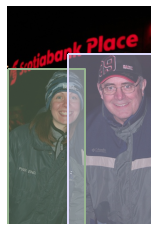

In [28]:
if __name__ == '__main__':
    from torch.utils.data import DataLoader
    from PyUtils.viz import cv_draw as CVDraw
    from PyUtils.bbox import BBoxes
    


    cocoRoot = f'/data/ylw/datasets/test/cocos'
    dataType = "val2017"
    json_path = os.path.join(cocoRoot, f'annotations/instances_{dataType}.json')
    img_path = '/data/ylw/datasets/test/cocos/train2017'
    cocodataset = COCODataset(json_path,img_path)
    print(f'{cocodataset.num_classes()=}')
    # {'img':array,'annot':array}
    # print(cocodataset.__getitem__(285))
    # for image_index in cocodataset.image_ids:
    #     print(image_index)
    #
    # print(cocodataset.labels)
    # print(cocodataset.load_annotations(324))
    # print(cocodataset.coco.getImgIds())
    dataloader_train = DataLoader(cocodataset, num_workers=3)

    # Display image and label.
    train = next(iter(dataloader_train))
    # dict
    # print(type(train))
    # {img:tensor,annot:tensor}
    # print(train)
    imgs = train['img'].numpy()
    bboxes = train['annot'].numpy()
    print(f'{imgs.shape=}  {bboxes.shape=}')
    for idx, (img, bbox) in enumerate(zip(imgs, bboxes)):
        print(f'{img.shape=}  {bbox.shape=}')
        img = (img * 255).astype(np.uint8)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = img.astype(np.uint8)
        plt.imshow(img); plt.axis('off')
        cocodataset.coco.showAnns(
            anns=[{
                'segmentation': [[]], 
                'iscrowd': 0, 
                'image_id': 20, 
                'bbox': bbox[0, 0:4], # [192, 111, 69, 129], 
                'area': 8901.0, 
                'category_id': 14, 
                'id': 55
            },
            {
                'segmentation': [[]], 
                'iscrowd': 0, 
                'image_id': 20, 
                'bbox': bbox[1, 0:4], # [192, 111, 69, 129], 
                'area': 8901.0, 
                'category_id': 14, 
                'id': 55
            }], 
            draw_bbox=True
        )
        

## coco eval

#### 例子

In [ ]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import skimage.io as io
import pylab,json
import argparse

if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    parser.add_argument("-g", "--gt", type=str, help="Assign the groud true path.", default=None)
    parser.add_argument("-d", "--dt", type=str, help="Assign the detection result path.", default=None)
    args = parser.parse_args()

    cocoGt = COCO(args.gt)    
    cocoDt = cocoGt.loadRes(args.dt)
    cocoEval = COCOeval(cocoGt, cocoDt, "keypoints")
    cocoEval.evaluate()
    cocoEval.accumulate()
    cocoEval.summarize()

cocoEval = COCOeval(cocoGt, cocoDt, "keypoints")中第三个参数为iouType参数，'segm'表示分割，'bbox'表示目标检测，'keypoints'表示人体关键点检测